## Pyspark

In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
import gc
spark = SparkSession.builder.master("local[1]").appName("EHR").getOrCreate()

## Showing label counts:

In [246]:
# Import data into dataframe
df = spark.read.csv("balancData.csv", header=True, inferSchema=True)

# Showing the different label counts
df.groupBy('label').count().show()
gc.collect()
# Creating a list of all column names that are features (minus the last column which is the label)
features_list = df.columns[:-1]
# features_list

+-----+-----+
|label|count|
+-----+-----+
|    1| 9735|
|    0| 9735|
+-----+-----+



## Transforming the vector and forming the dataframe:

In [247]:
# Importing the vector assembler module from pyspark
from pyspark.ml.feature import VectorAssembler

# Using the VectorAssembler method to create a vector of features
feature_vector_assembler = VectorAssembler(inputCols=features_list,
                                           outputCol="feature_vector")

# Transforming the vector and mounting it to the dataframe
df = feature_vector_assembler.transform(df)

# Showing the frist row of the dataframe to illustrate that the feature vector has been added to the dataframe
df.take(1)

[Row(Gender=1, pH1=-0.9667304460815365, pH2=0.3101074784827635, pCO2=0.9139223165427528, Sodium=0.0877891360317685, Glucose1=-0.07718891798005709, Glucose2=-0.25726631077956813, Lactate=2.7539346919060748, Chloride=-0.1680928492985376, Potassium=0.16342800612951874, Creatinine=0.14203397959974753, Hemoglobin1=-1.4088879735418802, Hemoglobin2=-1.3883112450182808, Urea Nitrogen=0.5885442925168796, Sodium, Whole Blood=0.19464213611504833, Chloride, Whole Blood=1.4775950160686262, Potassium, Whole Blood=-0.21292303507327479, label=0, feature_vector=DenseVector([1.0, -0.9667, 0.3101, 0.9139, 0.0878, -0.0772, -0.2573, 2.7539, -0.1681, 0.1634, 0.142, -1.4089, -1.3883, 0.5885, 0.1946, 1.4776, -0.2129]))]

In [248]:
# creating a dataframe for the model to fit to
model_df = df.select(["feature_vector","label"])
# Splitting the data into training, test, and validation dataframes using a the randomSplit method with a seed to standardize the output sizes across multiple runs of the file
training_df, test_df = model_df.randomSplit([0.8, 0.2], seed=22)

# Showing the number of rows in the dataframe
print("Training data count: ", training_df.count())
# Showing the number of rows in the dataframe
print("Test data count: ",test_df.count())
# Showing the total rows across the split dataframes
print("Check if total count is right: ", training_df.count() + test_df.count()== df.count())


Training data count:  15535


Test data count:  3935


Check if total count is right:  True


In [249]:
import time
# Finding the number of true positive results
def trueOrFalse(test_results):
    tp = test_results[(test_results.label==1) & (test_results.prediction==1)].count()
    # Finding the number of true negative results
    tn = test_results[(test_results.label==0) & (test_results.prediction==0)].count()
    # Finding the number of false positive results
    fp = test_results[(test_results.label==0) & (test_results.prediction==1)].count()
    # Finding the number of false negative results
    fn = test_results[(test_results.label==1) & (test_results.prediction==0)].count()
    return tp, tn, fp, fn
from pyspark.mllib.evaluation import MulticlassMetrics
def Eval2(test_results):
    rdd = test_results.select("prediction","label")
    rdd.schema
    rdd = rdd.withColumn("label", rdd["label"].cast('double')) 
    rdd.schema
    rdd = rdd.rdd
    rdd = rdd.map(tuple)
    metrics = MulticlassMetrics(rdd)
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    # print("Summary Stats")
    # print("Precision = %s" % precision)
    # print("Recall = %s" % recall)
    # print("F1 Score = %s" % f1Score)
    
    # Statistics by class
    training_rdd = training_df.withColumn("label", training_df["label"].cast('double'))
    labels = training_rdd.rdd.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        
    # Weighted stats
    print("Accuracy = %s" % metrics.accuracy)
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())


## Logistic regression

In [250]:
# Importing the Logistic Regression model from pyspark ml library
from pyspark.ml.classification import LogisticRegression
# ==================
start_time = time.time()
# Fitting the model and storing it to a variable
log_reg = LogisticRegression(featuresCol="feature_vector", labelCol="label").fit(training_df)
# Showing the model
end_time = time.time()
print("Logistic regression model fitting time: ", end_time-start_time)
# ==================
start_time = time.time()
# Training the model with the training data and storing the predictions in a variable
test_resultsLog = log_reg.evaluate(test_df).predictions
end_time = time.time()
print("Logistic regression model predicting time: ", end_time-start_time)


Logistic regression model fitting time:  2.6503100395202637
Logistic regression model predicting time:  0.24041247367858887


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0| 1486|
|    0|       1.0|  478|
|    1|       0.0|  751|
|    1|       1.0| 1220|
+-----+----------+-----+



Class 0.0 precision = 0.6642825212337953
Class 0.0 recall = 0.7566191446028513
Class 1.0 precision = 0.71849234393404
Class 1.0 recall = 0.6189751395230847
Accuracy = 0.6876747141041931
Weighted recall = 0.6876747141041931
Weighted precision = 0.691435649707031
Weighted F(1) Score = 0.6862032453769922


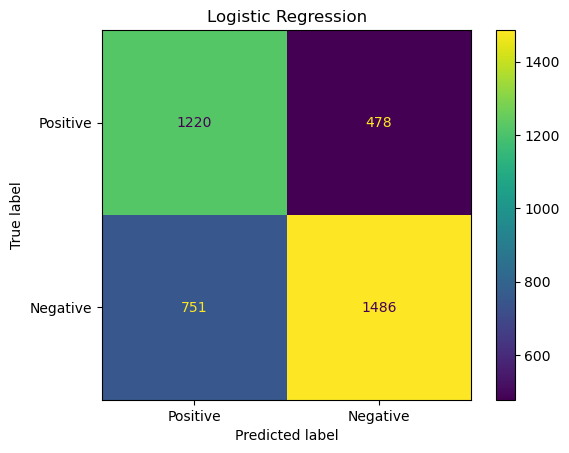

In [251]:
from pyspark.sql.functions import asc
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
# ==================
test_resultsLog.groupBy("label", "prediction").count().sort(asc("label"), asc("prediction")).show()
tpLog, tnLog, fpLog, fnLog =  trueOrFalse(test_resultsLog)
# ==================
Eval2(test_resultsLog)
# ==================
confusion_matrix = numpy.array([[tpLog, fpLog], [fnLog, tnLog]])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Negative'])
cm_display.plot()
plt.title("Logistic Regression")
plt.savefig('./Log_Reg_CM.png')
plt.show()

In [235]:
# # Importing multiclass classification evaluator from pyspark
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# # Save the evalutor to a variable with the resuts input and metric
# multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName='accuracy')

# # Returns the accuarcy given the test results data
# # Showing you can get the accuracy a different way
# multi_evaluator.evaluate(test_results)

## SVM

SVM model fitting time:  5.783548355102539
SVM model predicting time:  0.07319355010986328
Class 0.0 precision = 0.6476705490848585
Class 0.0 recall = 0.7927698574338086
Class 1.0 precision = 0.7341606792945787
Class 1.0 recall = 0.5702688990360223
Accuracy = 0.6813214739517154
Weighted recall = 0.6813214739517154
Weighted precision = 0.6909925431492445
Weighted F(1) Score = 0.677352350552925


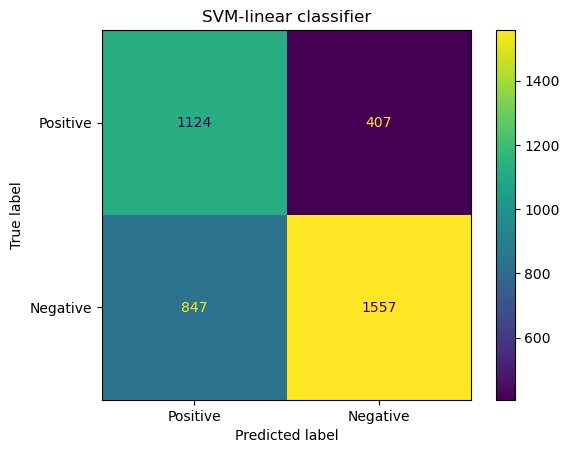

In [245]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline

df = spark.read.csv("balancData.csv", header=True, inferSchema=True)
training_df, test_df = df.randomSplit([0.8, 0.2], seed=22)

features_list = ['Gender','pH1','pH2','pCO2','Sodium','Glucose1','Glucose2',
                 'Lactate','Chloride','Potassium','Creatinine','Hemoglobin1',
                 'Hemoglobin2','Urea Nitrogen','Sodium, Whole Blood',
                 'Chloride, Whole Blood', 'Potassium, Whole Blood']

feature_vector_assembler = VectorAssembler(inputCols=df.columns[:-1],
                                           outputCol="features")

# ==================
# Don't do it! 
# df = feature_vector_assembler.transform(df)
# training_df = feature_vector_assembler.transform(training_df)
# test_df = feature_vector_assembler.transform(test_df)
# ==================

# Initialize LinearSVC model
svm = LinearSVC(labelCol="label")

# Create a pipeline
pipeline = Pipeline(stages=[feature_vector_assembler, svm])
# ==================
start_time = time.time()
# Fit the pipeline to the training data
svmmodel = pipeline.fit(training_df)
end_time = time.time()
print("SVM model fitting time: ", end_time-start_time)
# ==================
start_time = time.time()
# Make predictions
test_resultsSVM = svmmodel.transform(test_df)
end_time = time.time()
print("SVM model predicting time: ", end_time-start_time)
# ==================
tpSVM, tnSVM, fpSVM, fnSVM =  trueOrFalse(test_resultsSVM)
# ==================
# Finding the accuracy of the model manually
Eval2(test_resultsSVM)
# ==================
# Plot
confusion_matrix = numpy.array([[tpSVM, fpSVM], [fnSVM, tnSVM]])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Negative'])
cm_display.plot()
plt.title("SVM-linear classifier")
plt.savefig('./SVM_CM.png')
plt.show()
